In [25]:
from __future__ import annotations

import json
import random
import statistics
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

# ==============
# CONFIG
# ==============
DATA_ROOT = Path("/Users/leehw/Documents/likelion/2nd_project/SDLane")
SPLITS = ["train", "test"]
IMG_SUBDIR = "images"
LBL_SUBDIR = "labels"

IMG_EXTS = {".jpg", ".jpeg", ".png"}
JSON_EXTS = {".json"}

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Visualization
N_VIS = 12
MAX_LANES_DRAW = 12
LINE_THICKNESS = 2
POINT_RADIUS = 2

print("✅ Config loaded:", DATA_ROOT)


✅ Config loaded: /Users/leehw/Documents/likelion/2nd_project/SDLane


In [4]:
@dataclass
class Sample:
    split: str
    img_path: Path
    json_path: Optional[Path]  # None if missing


def is_image(p: Path) -> bool:
    return p.suffix.lower() in IMG_EXTS

def is_json(p: Path) -> bool:
    return p.suffix.lower() in JSON_EXTS


def scan_split(split: str) -> List[Sample]:
    split_root = DATA_ROOT / split
    img_root = split_root / IMG_SUBDIR
    lbl_root = split_root / LBL_SUBDIR

    img_files = []
    json_files = []

    # images/*hash*/*.jpg
    for d in img_root.glob("*"):
        if d.is_dir():
            img_files.extend([p for p in d.glob("*") if p.is_file() and is_image(p)])

    # labels/*hash*/*.json
    for d in lbl_root.glob("*"):
        if d.is_dir():
            json_files.extend([p for p in d.glob("*") if p.is_file() and is_json(p)])

    def key_dir_stem(p: Path) -> Tuple[str, str]:
        return (p.parent.name, p.stem)

    img_map = {key_dir_stem(p): p for p in img_files}
    json_map = {key_dir_stem(p): p for p in json_files}

    samples: List[Sample] = []
    for k, imgp in img_map.items():
        samples.append(Sample(split=split, img_path=imgp, json_path=json_map.get(k)))

    # stats
    missing_json = sum(1 for s in samples if s.json_path is None)
    unmatched_json = len(set(json_map.keys()) - set(img_map.keys()))
    print(f"[{split}] images={len(img_files):,}, jsons={len(json_files):,}")
    print(f"[{split}] missing_json_for_images={missing_json:,}, json_without_image={unmatched_json:,}")

    return samples


all_samples = []
for sp in SPLITS:
    all_samples.extend(scan_split(sp))

print("✅ Total paired candidates:", len(all_samples))


[train] images=39,096, jsons=39,096
[train] missing_json_for_images=0, json_without_image=0
[test] images=3,853, jsons=3,853
[test] missing_json_for_images=0, json_without_image=0
✅ Total paired candidates: 42949


In [5]:
# show a few samples
for s in random.sample(all_samples, k=min(5, len(all_samples))):
    print("—")
    print("split:", s.split)
    print("img :", s.img_path)
    print("json:", s.json_path)


—
split: test
img : /Users/leehw/Documents/likelion/2nd_project/SDLane/test/images/7de15ead425a6d75135afbf0e8a0fa418bc56aad/0099.jpg
json: /Users/leehw/Documents/likelion/2nd_project/SDLane/test/labels/7de15ead425a6d75135afbf0e8a0fa418bc56aad/0099.json
—
split: train
img : /Users/leehw/Documents/likelion/2nd_project/SDLane/train/images/3516aa4b1a494ecc278b95e6fa567fa74e4e270a/1080.jpg
json: /Users/leehw/Documents/likelion/2nd_project/SDLane/train/labels/3516aa4b1a494ecc278b95e6fa567fa74e4e270a/1080.json
—
split: train
img : /Users/leehw/Documents/likelion/2nd_project/SDLane/train/images/f8a3b1798c97d44944a1974e55d5c15911151a3d/1722.jpg
json: /Users/leehw/Documents/likelion/2nd_project/SDLane/train/labels/f8a3b1798c97d44944a1974e55d5c15911151a3d/1722.json
—
split: train
img : /Users/leehw/Documents/likelion/2nd_project/SDLane/train/images/57ee9771102ab5902617458fac61ac9e00ffa912/0570.jpg
json: /Users/leehw/Documents/likelion/2nd_project/SDLane/train/labels/57ee9771102ab5902617458fac61ac

In [6]:
def read_image_shape(img_path: Path) -> Tuple[int, int, int]:
    img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    if img is None:
        raise RuntimeError(f"Failed to read image: {img_path}")
    h, w, c = img.shape
    return h, w, c


shapes = []
bad_images = 0

for s in tqdm(all_samples, desc="Reading image shapes"):
    try:
        shapes.append(read_image_shape(s.img_path))
    except Exception:
        bad_images += 1

hs = [x[0] for x in shapes]
ws = [x[1] for x in shapes]
cs = [x[2] for x in shapes]

print("✅ Image read ok:", len(shapes), " / bad:", bad_images)
print(f"Height: min={min(hs)}, max={max(hs)}, mean={statistics.mean(hs):.1f}")
print(f"Width : min={min(ws)}, max={max(ws)}, mean={statistics.mean(ws):.1f}")
print("Channels unique:", sorted(set(cs)))
print("Most common (H,W):", statistics.mode(list(zip(hs, ws))))


Reading image shapes: 100%|██████████| 42949/42949 [03:15<00:00, 219.75it/s]

✅ Image read ok: 42949  / bad: 0
Height: min=1208, max=1208, mean=1208.0
Width : min=1920, max=1920, mean=1920.0
Channels unique: [3]
Most common (H,W): (1208, 1920)


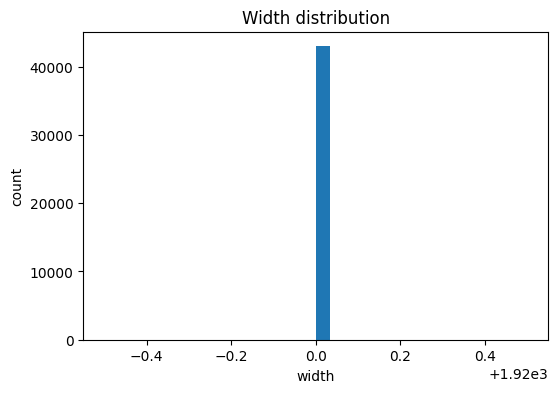

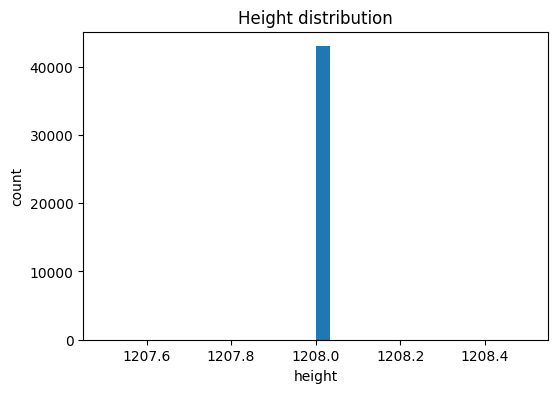

In [7]:
plt.figure(figsize=(6,4))
plt.hist(ws, bins=30)
plt.title("Width distribution")
plt.xlabel("width")
plt.ylabel("count")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(hs, bins=30)
plt.title("Height distribution")
plt.xlabel("height")
plt.ylabel("count")
plt.show()


In [8]:
def read_json(p: Path) -> Any:
    with p.open("r", encoding="utf-8") as f:
        return json.load(f)

top_keys_count: Dict[str, int] = {}
json_read_ok = 0
json_read_fail = 0
example_signatures = []

for s in tqdm(all_samples, desc="Reading JSON (schema)"):
    if s.json_path is None:
        continue
    try:
        data = read_json(s.json_path)
        json_read_ok += 1
        if isinstance(data, dict):
            for k in data.keys():
                top_keys_count[k] = top_keys_count.get(k, 0) + 1
            # signature sample (shallow)
            if len(example_signatures) < 5:
                example_signatures.append((s.json_path, list(data.keys())[:20]))
    except Exception:
        json_read_fail += 1

print("✅ JSON read ok:", json_read_ok, "/ fail:", json_read_fail)
print("Top-level keys (top 30):")
for k, v in sorted(top_keys_count.items(), key=lambda x: -x[1])[:30]:
    print(f"  {k:25s} {v:,}")

print("\nExample top-level keys from few files:")
for p, keys in example_signatures:
    print("—", p.name, ":", keys)


Reading JSON (schema): 100%|██████████| 42949/42949 [00:09<00:00, 4564.29it/s]

✅ JSON read ok: 42949 / fail: 0
Top-level keys (top 30):
  geometry                  42,949
  idx                       42,949

Example top-level keys from few files:
— 0071.json : ['geometry', 'idx']
— 0717.json : ['geometry', 'idx']
— 1409.json : ['geometry', 'idx']
— 0703.json : ['geometry', 'idx']
— 0065.json : ['geometry', 'idx']


In [9]:
@dataclass
class Polyline:
    points: np.ndarray  # [N,2]
    meta: Dict[str, Any]


def _as_points_list(obj: Any) -> Optional[np.ndarray]:
    """
    Try parse to Nx2:
    - [[x,y], ...]
    - [{"x":..,"y":..}, ...]
    """
    if isinstance(obj, list) and len(obj) >= 2:
        # list of lists
        if all(isinstance(p, (list, tuple)) and len(p) >= 2 for p in obj):
            try:
                arr = np.array([[float(p[0]), float(p[1])] for p in obj], dtype=np.float32)
                return arr
            except Exception:
                return None
        # list of dicts
        if all(isinstance(p, dict) for p in obj) and all(("x" in p and "y" in p) for p in obj):
            try:
                arr = np.array([[float(p["x"]), float(p["y"])] for p in obj], dtype=np.float32)
                return arr
            except Exception:
                return None
    return None


def extract_polylines_from_json(data: Any) -> List[Polyline]:
    """
    Recursively traverse and extract any list that looks like Nx2 points.
    """
    out: List[Polyline] = []

    def visit(node: Any, path: str):
        pts = _as_points_list(node)
        if pts is not None and pts.shape[0] >= 2:
            out.append(Polyline(points=pts, meta={"path": path}))
            return

        if isinstance(node, dict):
            for k, v in node.items():
                visit(v, f"{path}.{k}" if path else k)
        elif isinstance(node, list):
            for i, v in enumerate(node):
                visit(v, f"{path}[{i}]")

    # try likely keys first
    if isinstance(data, dict):
        for k in ["lanes", "lines", "polylines", "annotations", "objects", "labels", "lane_lines"]:
            if k in data:
                visit(data[k], k)

    visit(data, "")
    return out


In [10]:
lane_counts = []
point_counts = []
paths_counter: Dict[str, int] = {}
no_polyline = 0
json_missing = 0

for s in tqdm(all_samples, desc="Extracting polylines"):
    if s.json_path is None:
        json_missing += 1
        continue
    try:
        data = read_json(s.json_path)
        polylines = extract_polylines_from_json(data)
        if len(polylines) == 0:
            no_polyline += 1
            continue

        lane_counts.append(len(polylines))
        point_counts.extend([pl.points.shape[0] for pl in polylines])

        # where were they found?
        for pl in polylines[:50]:
            p = pl.meta.get("path", "")
            paths_counter[p] = paths_counter.get(p, 0) + 1

    except Exception:
        pass

print("JSON missing:", json_missing)
print("Files with no polyline extracted:", no_polyline)
if lane_counts:
    print(f"Polylines per file: min={min(lane_counts)}, max={max(lane_counts)}, mean={statistics.mean(lane_counts):.2f}")
if point_counts:
    print(f"Points per polyline: min={min(point_counts)}, max={max(point_counts)}, mean={statistics.mean(point_counts):.2f}")

print("\nMost common JSON paths containing polylines (top 15):")
for k, v in sorted(paths_counter.items(), key=lambda x: -x[1])[:15]:
    print(f"  {k:40s} {v:,}")


Extracting polylines: 100%|██████████| 42949/42949 [00:11<00:00, 3811.27it/s]

JSON missing: 0
Files with no polyline extracted: 2
Polylines per file: min=1, max=7, mean=3.90
Points per polyline: min=5, max=50, mean=37.70

Most common JSON paths containing polylines (top 15):
  geometry[0]                              42,947
  geometry[1]                              42,710
  geometry[2]                              40,346
  geometry[3]                              29,364
  geometry[4]                              9,711
  geometry[5]                              2,460
  geometry[6]                              139


In [11]:
def draw_polylines_on_image(img_bgr: np.ndarray, polylines: List[Polyline]) -> np.ndarray:
    out = img_bgr.copy()
    h, w = out.shape[:2]

    # limit for readability
    polylines = polylines[:MAX_LANES_DRAW]

    for i, pl in enumerate(polylines):
        pts = pl.points.copy()

        # if normalized coords (0~1) guess: scale
        if np.nanmax(pts[:, 0]) <= 2.0 and np.nanmax(pts[:, 1]) <= 2.0:
            pts[:, 0] *= w
            pts[:, 1] *= h

        pts_int = np.round(pts).astype(np.int32)

        # draw segments
        for j in range(len(pts_int) - 1):
            x1, y1 = pts_int[j]
            x2, y2 = pts_int[j + 1]
            cv2.line(out, (x1, y1), (x2, y2), (0, 255, 0), LINE_THICKNESS)

        # draw points
        for (x, y) in pts_int:
            cv2.circle(out, (x, y), POINT_RADIUS, (0, 0, 255), -1)

        # label lane index
        x0, y0 = pts_int[0]
        cv2.putText(out, f"{i}", (x0, y0), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    return out


In [18]:
s

Sample(split='train', img_path=PosixPath('/Users/leehw/Documents/likelion/2nd_project/SDLane/train/images/c27129f39cdc10ec70ee9a0ed991b61cf24f32c4/0265.jpg'), json_path=PosixPath('/Users/leehw/Documents/likelion/2nd_project/SDLane/train/labels/c27129f39cdc10ec70ee9a0ed991b61cf24f32c4/0265.json'))

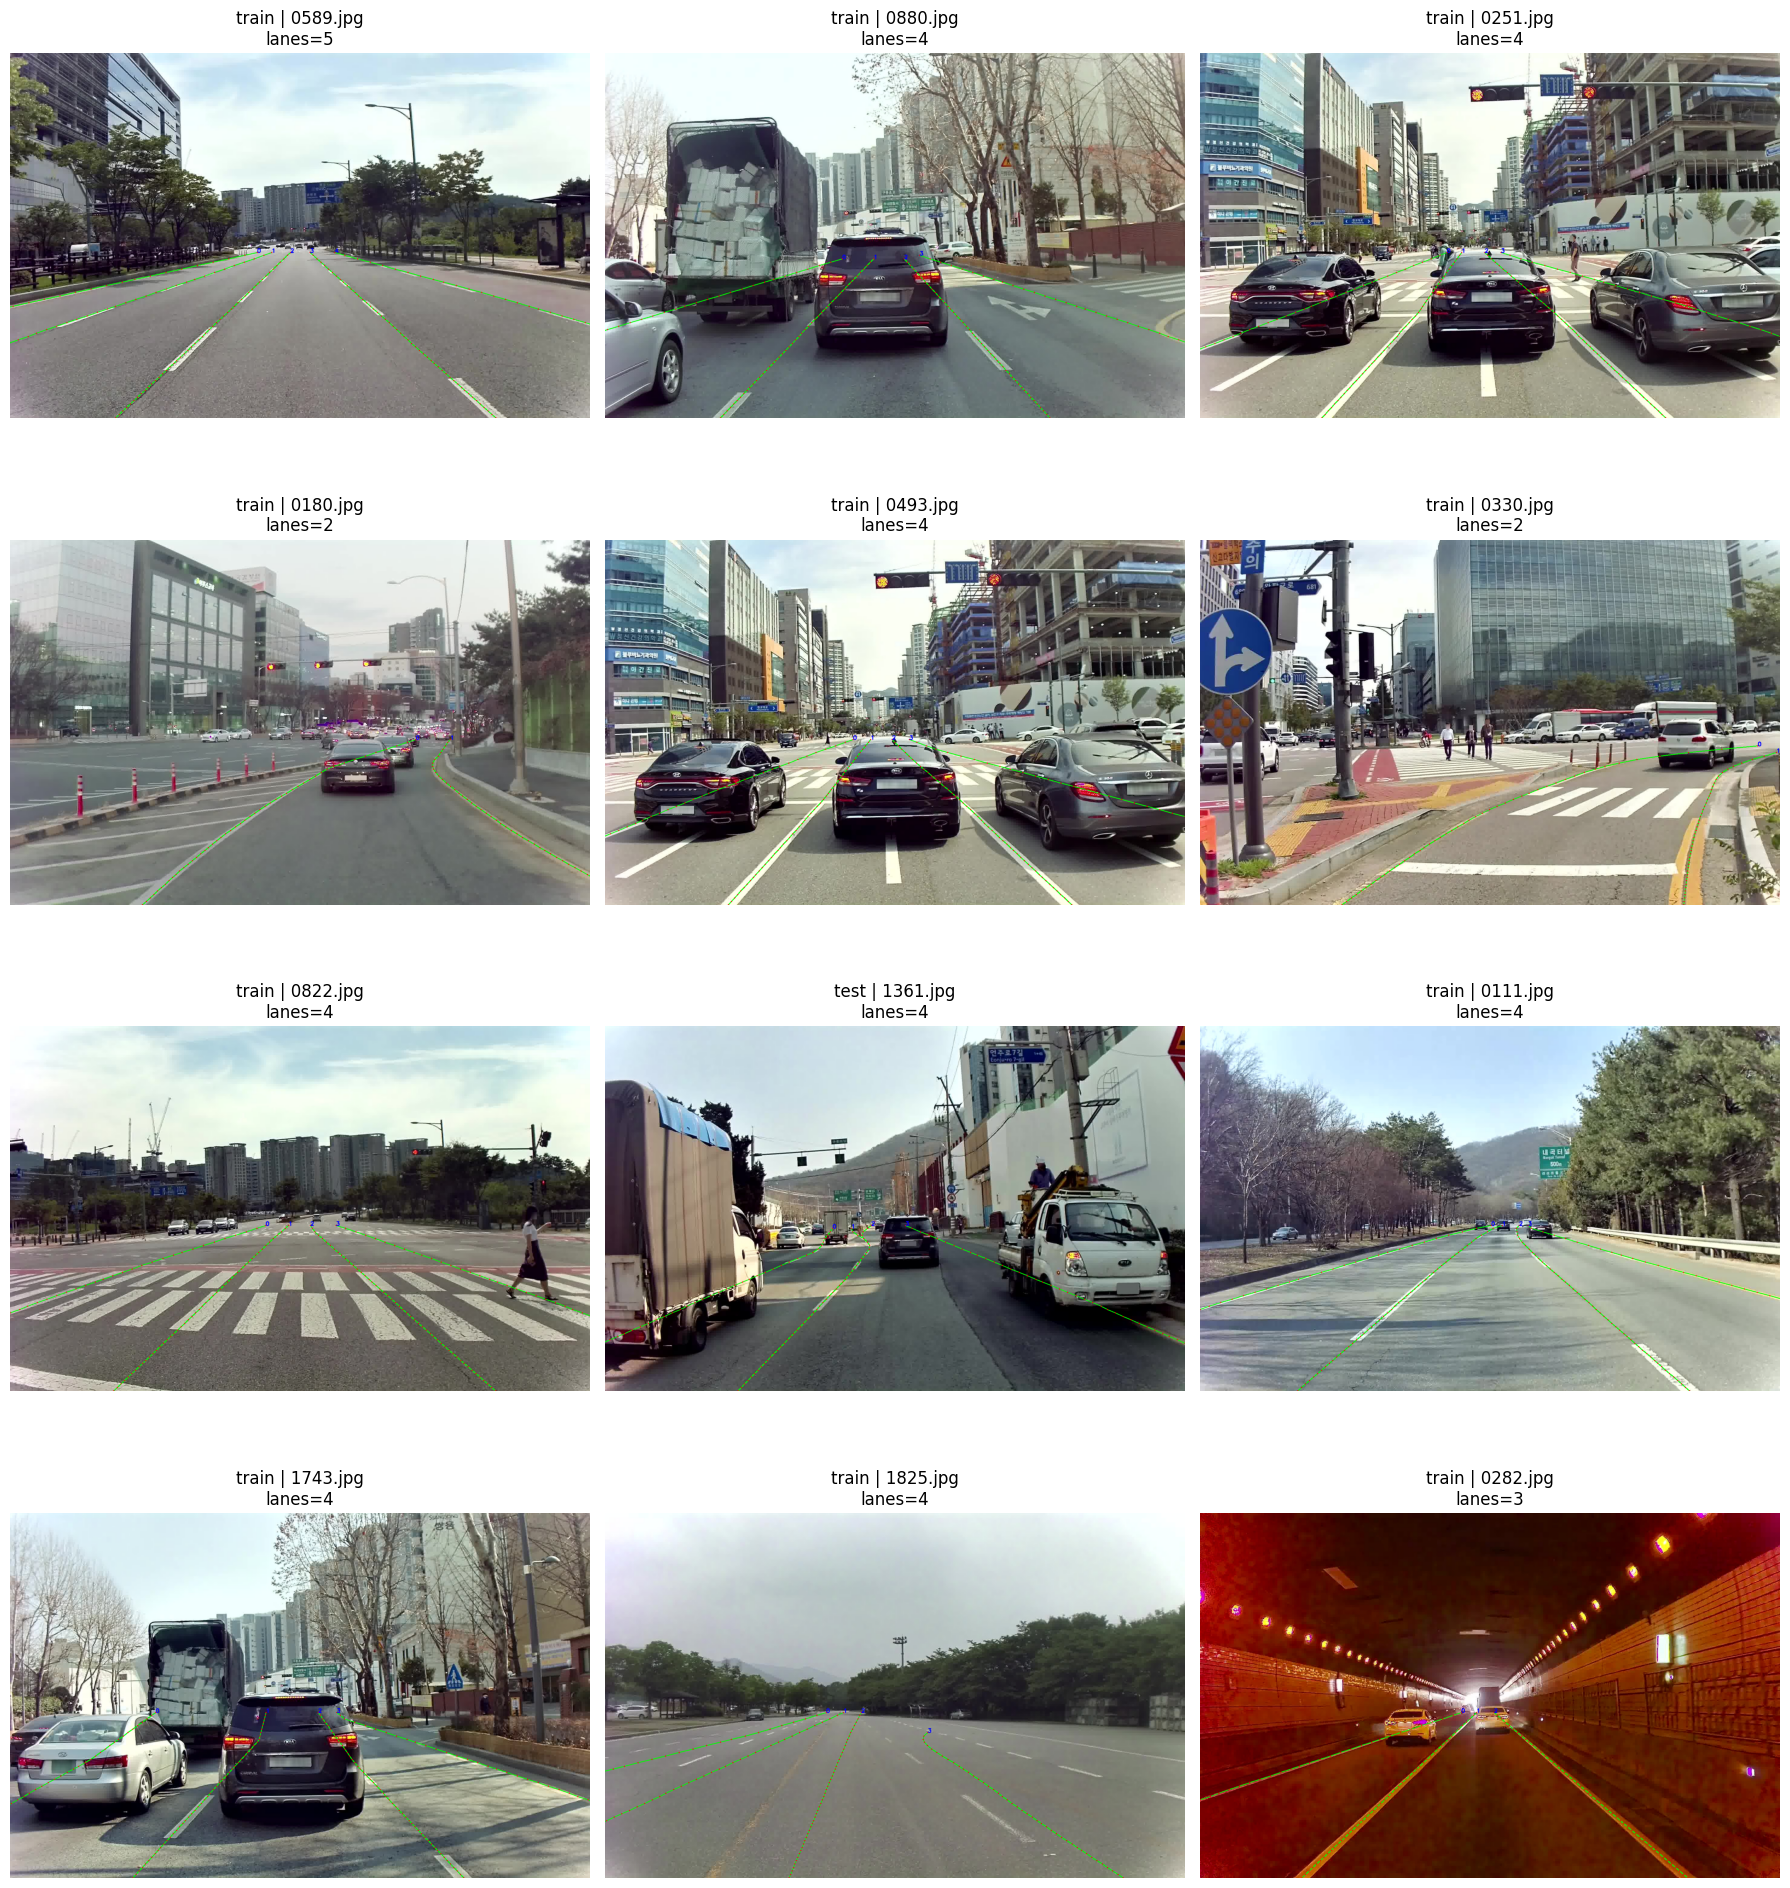

In [52]:
# pick samples that have json
candidates = [s for s in all_samples if s.json_path is not None]
picked = random.sample(candidates, k=min(N_VIS, len(candidates)))

fig, axes = plt.subplots(nrows=(len(picked)+2)//3, ncols=3, figsize=(18, 5*((len(picked)+2)//3)))
axes = np.array(axes).reshape(-1)

for ax, s in zip(axes, picked):
    img = cv2.imread(str(s.img_path), cv2.IMREAD_COLOR)
    data = read_json(s.json_path)
    polylines = extract_polylines_from_json(data)
    vis = draw_polylines_on_image(img, polylines)

    ax.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    ax.set_title(f"{s.split} | {s.img_path.name}\nlanes={len(polylines)}")
    ax.axis("off")

# hide leftover axes
for ax in axes[len(picked):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [23]:
# find a few files where polyline extraction failed (lane=0)
bad_cases = []
for s in candidates:
    try:
        data = read_json(s.json_path)
        polylines = extract_polylines_from_json(data)
        if len(polylines) == 0:
            bad_cases.append(s)
    except Exception:
        pass

print("Bad cases (no polyline extracted):", len(bad_cases))
for s in bad_cases[:10]:
    print("—", s.split, s.img_path, "| json:", s.json_path.name)


Bad cases (no polyline extracted): 2
— train /Users/leehw/Documents/likelion/2nd_project/SDLane/train/images/dc55c34f96ceb3076cb3af5c8ad4db68775fb98f/2708.jpg | json: 2708.json
— train /Users/leehw/Documents/likelion/2nd_project/SDLane/train/images/dc55c34f96ceb3076cb3af5c8ad4db68775fb98f/2694.jpg | json: 2694.json


In [ ]:
train_len = len(glob(str(DATA_ROOT)  + "/train/images/*/*.jpg"))
test_len = len(glob(str(DATA_ROOT)  + "/test/images/*/*.jpg"))

print(f"len of train images: {train_len}\nlen of test images: {test_len}")

len of train images: 39096
 len of test images: 3853


In [43]:
train_file_list = glob(str(DATA_ROOT)  + "/train/images/*/*.jpg")

traub_file_name_len =  len(set([file.split('/')[-1] for file in train_file_list]))

test_file_list = glob(str(DATA_ROOT)  + "/test/images/*/*.jpg")

test_file_name_len =  len(set([file.split('/')[-1] for file in test_file_list]))

print(f"len of train file names: {traub_file_name_len}\nlen of test file names: {test_file_name_len}")

len of train file names: 2999
len of test file names: 2104


# 파일 이름만으로는 구분 불가능

# 파일 넣으면 오버레이 출력하는 함수

In [44]:
from __future__ import annotations

import json
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple

import cv2
import numpy as np
import matplotlib.pyplot as plt


def _read_json(p: Path) -> Any:
    with p.open("r", encoding="utf-8") as f:
        return json.load(f)


def _find_pair_paths(any_path: str | Path) -> Tuple[Path, Path]:
    """
    Given either an image path or a json path, find its paired counterpart.
    Assumes directory structure:
      .../SDLane/{train|test}/{images|labels}/{hash_dir}/{stem}.{jpg|json}
    Returns: (img_path, json_path)
    """
    p = Path(any_path).expanduser().resolve()
    if not p.exists():
        raise FileNotFoundError(f"Path not found: {p}")

    suf = p.suffix.lower()

    # If given JSON
    if suf == ".json":
        json_path = p
        # try same dir replacement: labels -> images, .json -> .jpg/.png
        parent = json_path.parent
        stem = json_path.stem

        # same hash dir, switch labels->images if present
        parts = list(parent.parts)
        if "labels" in parts:
            parts[parts.index("labels")] = "images"
        img_dir = Path(*parts)

        # try common image extensions
        for ext in [".jpg", ".jpeg", ".png"]:
            cand = img_dir / f"{stem}{ext}"
            if cand.exists():
                return cand, json_path

        # fallback: search nearby
        for cand in img_dir.glob(f"{stem}.*"):
            if cand.suffix.lower() in {".jpg", ".jpeg", ".png"}:
                return cand, json_path

        raise FileNotFoundError(f"Paired image not found for json: {json_path}")

    # If given image
    if suf in {".jpg", ".jpeg", ".png"}:
        img_path = p
        parent = img_path.parent
        stem = img_path.stem

        parts = list(parent.parts)
        if "images" in parts:
            parts[parts.index("images")] = "labels"
        json_dir = Path(*parts)

        cand = json_dir / f"{stem}.json"
        if cand.exists():
            return img_path, cand

        # fallback: search nearby
        for cand in json_dir.glob(f"{stem}.json"):
            if cand.exists():
                return img_path, cand

        raise FileNotFoundError(f"Paired json not found for image: {img_path}")

    raise ValueError(f"Unsupported file type: {p.suffix}")


def _extract_geometry_polylines(data: Any) -> List[np.ndarray]:
    """
    SDLane-specific (based on your EDA):
      data["geometry"] is a list of polylines
      each polyline is [[x,y], [x,y], ...]
    Returns list of (N,2) float arrays.
    """
    polylines: List[np.ndarray] = []
    if not isinstance(data, dict):
        return polylines
    if "geometry" not in data:
        return polylines
    geom = data["geometry"]
    if not isinstance(geom, list):
        return polylines

    for g in geom:
        if isinstance(g, list) and len(g) >= 2 and isinstance(g[0], (list, tuple)) and len(g[0]) >= 2:
            try:
                arr = np.array([[float(pt[0]), float(pt[1])] for pt in g], dtype=np.float32)
                if arr.ndim == 2 and arr.shape[1] == 2:
                    polylines.append(arr)
            except Exception:
                continue

    return polylines


def visualize_sdlane_sample(
    path: str | Path,
    max_lanes: int = 12,
    line_thickness: int = 2,
    point_radius: int = 2,
    figsize: Tuple[int, int] = (14, 8),
) -> Dict[str, Any]:
    """
    Visualize one SDLane sample by overlaying geometry polylines on image.
    Input: path to either image or json
    Output: dict with paths + some quick stats
    """
    img_path, json_path = _find_pair_paths(path)

    img_bgr = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise RuntimeError(f"Failed to read image: {img_path}")

    data = _read_json(json_path)
    polylines = _extract_geometry_polylines(data)

    h, w = img_bgr.shape[:2]

    # detect normalized coords (0~1 or 0~2-ish)
    all_pts = np.concatenate(polylines, axis=0) if len(polylines) else np.zeros((0, 2), dtype=np.float32)
    normalized = False
    if all_pts.shape[0] > 0:
        if all_pts[:, 0].max() <= 2.0 and all_pts[:, 1].max() <= 2.0:
            normalized = True

    vis = img_bgr.copy()
    polylines_draw = polylines[:max_lanes]

    for i, pts in enumerate(polylines_draw):
        pts2 = pts.copy()
        if normalized:
            pts2[:, 0] *= w
            pts2[:, 1] *= h

        pts_int = np.round(pts2).astype(np.int32)

        # draw segments
        for j in range(len(pts_int) - 1):
            x1, y1 = pts_int[j]
            x2, y2 = pts_int[j + 1]
            cv2.line(vis, (x1, y1), (x2, y2), (0, 255, 0), line_thickness)

        # draw points
        for (x, y) in pts_int:
            cv2.circle(vis, (x, y), point_radius, (0, 0, 255), -1)

        # lane index label
        x0, y0 = pts_int[0]
        cv2.putText(vis, f"{i}", (x0, y0), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    # show
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(
        f"{img_path.name} | lanes={len(polylines)} (draw {len(polylines_draw)}) | "
        f"{w}x{h} | normalized={normalized}"
    )
    plt.axis("off")
    plt.show()

    return {
        "img_path": str(img_path),
        "json_path": str(json_path),
        "image_size": (w, h),
        "num_polylines": len(polylines),
        "normalized_coords_detected": normalized,
    }


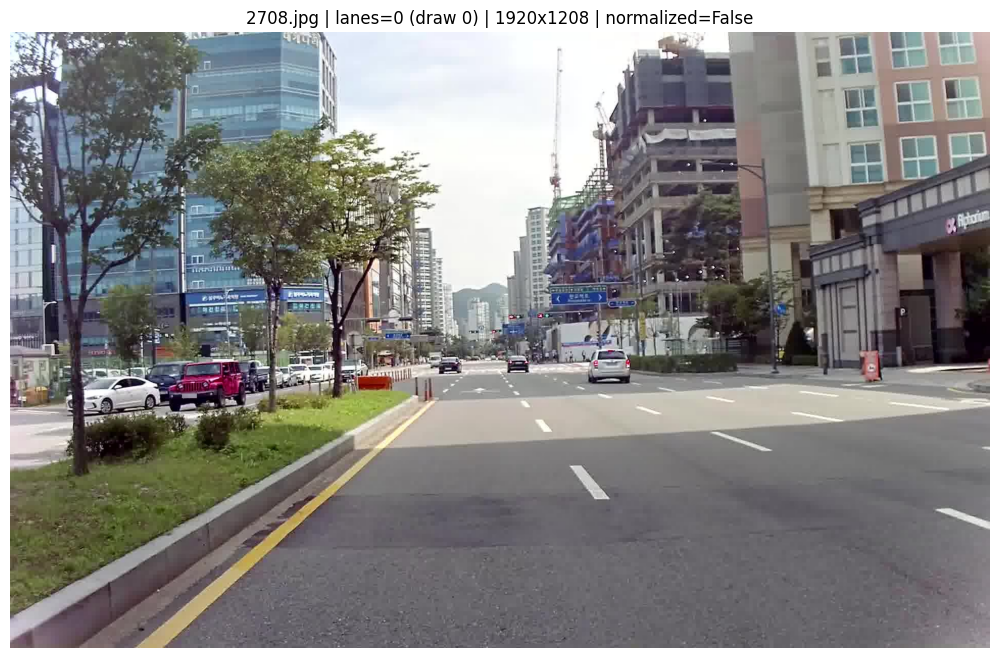

{'img_path': '/Users/leehw/Documents/likelion/2nd_project/SDLane/train/images/dc55c34f96ceb3076cb3af5c8ad4db68775fb98f/2708.jpg', 'json_path': '/Users/leehw/Documents/likelion/2nd_project/SDLane/train/labels/dc55c34f96ceb3076cb3af5c8ad4db68775fb98f/2708.json', 'image_size': (1920, 1208), 'num_polylines': 0, 'normalized_coords_detected': False}


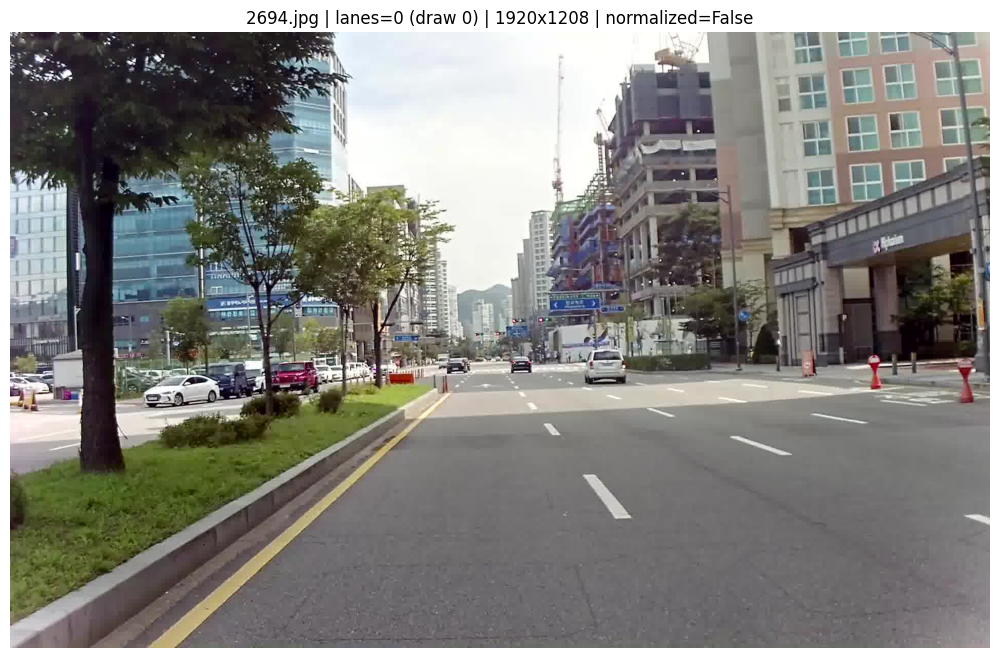

{'img_path': '/Users/leehw/Documents/likelion/2nd_project/SDLane/train/images/dc55c34f96ceb3076cb3af5c8ad4db68775fb98f/2694.jpg', 'json_path': '/Users/leehw/Documents/likelion/2nd_project/SDLane/train/labels/dc55c34f96ceb3076cb3af5c8ad4db68775fb98f/2694.json', 'image_size': (1920, 1208), 'num_polylines': 0, 'normalized_coords_detected': False}


In [48]:
info = visualize_sdlane_sample("/Users/leehw/Documents/likelion/2nd_project/SDLane/train/images/dc55c34f96ceb3076cb3af5c8ad4db68775fb98f/2708.jpg")
print(info)
# 이미지 경로 넣어도 되고
info = visualize_sdlane_sample("/Users/leehw/Documents/likelion/2nd_project/SDLane/train/images/dc55c34f96ceb3076cb3af5c8ad4db68775fb98f/2694.jpg")
print(info)

usage: ipykernel_launcher.py [-h] --data_root DATA_ROOT [--out_dir OUT_DIR]
                             [--workers WORKERS]
ipykernel_launcher.py: error: the following arguments are required: --data_root


SystemExit: 2

/Users/leehw/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
